In [22]:
!pip install inference-sdk

In [23]:

from inference_sdk import InferenceHTTPClient
import cv2
import matplotlib.pyplot as plt
from datetime import datetime
import os
import numpy as np
import easyocr
from twilio.rest import Client

In [24]:
# Roboflow API setup
CLIENT = InferenceHTTPClient(
    api_url="https://serverless.roboflow.com",
    api_key="zvk9zaWxnlyi6jkKUbTR"
)

In [25]:
import os
from dotenv import load_dotenv
load_dotenv()
TWILIO_ACCOUNT_SID = os.getenv('TWILIO_ACCOUNT_SID')
TWILIO_AUTH_TOKEN = os.getenv('TWILIO_AUTH_TOKEN')  # Replace with your Twilio Auth Token
TWILIO_PHONE_NUMBER = "+15677575158"             # Replace with your Twilio phone number
RECIPIENT_PHONE_NUMBER = "+919916957771"          # Replace with recipient's phone number

# Initialize Twilio client
twilio_client = Client(TWILIO_ACCOUNT_SID, TWILIO_AUTH_TOKEN)

In [26]:
# Initialize EasyOCR reader
reader = easyocr.Reader(['en'], gpu=False)  # Set gpu=True if you have GPU support

def detect_license_plate(image, region_of_interest=None):
    """
    Detect and recognize license plate text using EasyOCR.
    If region_of_interest is provided, only scan that area for better accuracy.
    """
    try:
        # If a specific region is provided, crop the image
        if region_of_interest is not None:
            x1, y1, x2, y2 = region_of_interest
            # Ensure coordinates are within image boundaries
            height, width = image.shape[:2]
            x1 = max(0, x1)
            y1 = max(0, y1)
            x2 = min(width, x2)
            y2 = min(height, y2)
            roi_image = image[y1:y2, x1:x2]
        else:
            roi_image = image
            
        # Apply preprocessing to enhance license plate visibility
        gray = cv2.cvtColor(roi_image, cv2.COLOR_BGR2GRAY)
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)
        
        # Apply threshold to make text more visible
        _, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        
        # Run OCR on the preprocessed image
        results = reader.readtext(binary)
        
        # Filter and process OCR results to extract license plate
        license_plate = ""
        confidence = 0
        license_box = None
        
        for (bbox, text, conf) in results:
            # Clean the text (remove spaces, standardize format)
            cleaned_text = ''.join(text.replace(' ', '').upper())
            
            # Use rules to identify if this text block is likely a license plate
            # License plates typically have a mix of letters and numbers
            if len(cleaned_text) >= 4 and any(c.isalpha() for c in cleaned_text) and any(c.isdigit() for c in cleaned_text):
                license_plate = cleaned_text
                confidence = conf
                
                # If using ROI, adjust bounding box coordinates back to original image
                if region_of_interest is not None:
                    adjusted_bbox = [
                        [bbox[0][0] + x1, bbox[0][1] + y1],
                        [bbox[1][0] + x1, bbox[1][1] + y1],
                        [bbox[2][0] + x1, bbox[2][1] + y1],
                        [bbox[3][0] + x1, bbox[3][1] + y1]
                    ]
                    license_box = adjusted_bbox
                else:
                    license_box = bbox
                break  # Take the first good license plate candidate
                
        return license_plate, confidence, license_box
    
    except Exception as e:
        print(f"Error in license plate detection: {e}")
        return "", 0, None


Using CPU. Note: This module is much faster with a GPU.


Processing image: /Users/saikalyansathish/Desktop/CAPSTONE PROJECT 2/1.jpeg


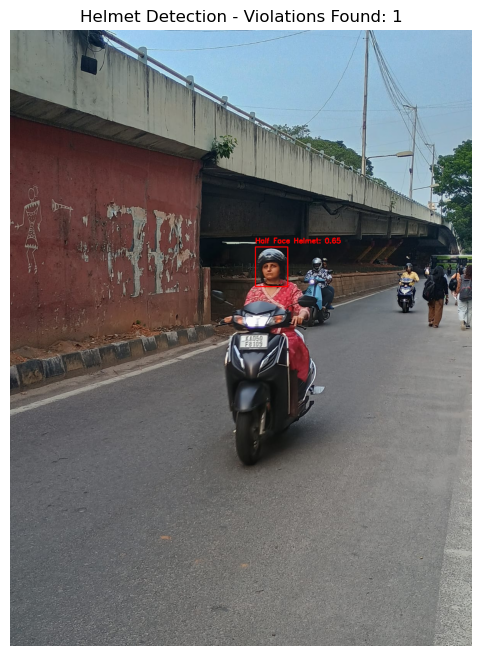

Violation logged to violation_logs/violation_20250516_141736.txt
Annotated image saved to violation_images/violation_20250516_141736.jpg
Violation notification sent! SID: SMd32c8aac420cbc00ceeb8ac6060f408d

Violation Summary:
- Total violations detected: 1
- Violation types: Half Face Helmet
- Log file: violation_logs/violation_20250516_141736.txt
- Image saved: violation_images/violation_20250516_141736.jpg


In [27]:
def detect_helmet(image_path):
    """Run helmet detection and return the results and the annotated image"""
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Image not loaded. Check the file path: {image_path}")
        return None, None, None
    
    # Get the base filename without extension
    filename = os.path.basename(image_path)
    
    # Run inference
    result = CLIENT.infer(image_path, model_id="fullface-helmet-helmet-no-helmet-detection/1")
    
    # Create a copy of the image for annotation
    annotated_image = image.copy()
    
    # List to store violation details
    violations = []
    
    # Draw bounding boxes and labels on the image for helmet detection
    for prediction in result["predictions"]:
        x1 = int(prediction["x"] - prediction["width"] / 2)
        y1 = int(prediction["y"] - prediction["height"] / 2)
        x2 = int(prediction["x"] + prediction["width"] / 2)
        y2 = int(prediction["y"] + prediction["height"] / 2)
        
        label = prediction["class"]
        confidence = prediction["confidence"]
        
        # Set color based on helmet type
        if label == "full-face helmet":
            color = (0, 255, 0)  # Green for full-face helmet (safe)
        else:
            # Red for violations (half-face helmet or without helmet)
            color = (0, 0, 255)
            
            # If this is a violation, try to find license plate in lower part of the image
            # Look in a region below the rider, which is where license plates typically are
            height, width = image.shape[:2]
            plate_search_y1 = min(y2 + 20, height - 1)  # Start below the rider
            plate_search_y2 = min(height, plate_search_y1 + 200)  # Search area height
            
            # Use rider's position to determine where to look horizontally
            search_width = int(width * 0.4)  # Search in 40% of image width
            plate_search_x1 = max(0, x1 - int(search_width/2))
            plate_search_x2 = min(width, x2 + int(search_width/2))
            
            # Define the license plate search region
            plate_roi = (plate_search_x1, plate_search_y1, plate_search_x2, plate_search_y2)
            
            # Detect license plate in the defined region
            license_plate, plate_conf, plate_box = detect_license_plate(image, plate_roi)
          
            # If no plate found in targeted area, try the whole lower half of image
            if not license_plate:
                plate_roi = (0, height//2, width, height)
                license_plate, plate_conf, plate_box = detect_license_plate(image, plate_roi)
            
            # If still no plate found, try the entire image as last resort
            if not license_plate:
                license_plate, plate_conf, plate_box = detect_license_plate(image)
            
            # Add violation with license plate info if available
            violation_data = {
                "type": label,
                "confidence": confidence,
                "location": (x1, y1, x2, y2),
                "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
                "license_plate": license_plate,
                "license_plate_confidence": plate_conf
            }
            
            violations.append(violation_data)
            
            # If license plate was found, mark it on the image
            if license_plate and plate_box is not None:
                # Convert EasyOCR box format to rectangle coordinates
                try:
                    min_x = min([p[0] for p in plate_box])
                    min_y = min([p[1] for p in plate_box])
                    max_x = max([p[0] for p in plate_box])
                    max_y = max([p[1] for p in plate_box])
                    
                    # Draw license plate box in blue
                    cv2.rectangle(annotated_image, 
                                 (int(min_x), int(min_y)), 
                                 (int(max_x), int(max_y)), 
                                 (255, 0, 0), 2)
                    
                    # Add license plate text
                    cv2.putText(annotated_image, 
                               f"Plate: {license_plate}", 
                               (int(min_x), int(min_y) - 10), 
                               cv2.FONT_HERSHEY_SIMPLEX, 
                               0.6, 
                               (255, 0, 0), 
                               2)
                except Exception as e:
                    print(f"Error drawing license plate box: {e}")
        
        # Draw bounding box and label for helmet detection
        cv2.rectangle(annotated_image, (x1, y1), (x2, y2), color, 2)
        cv2.putText(
            annotated_image, 
            f"{label}: {confidence:.2f}", 
            (x1, y1 - 10), 
            cv2.FONT_HERSHEY_SIMPLEX, 
            0.6, 
            color, 
            2
        )
    
    return violations, annotated_image, result

def send_violation_notification(violations, image_path):
    """Send notification about helmet violations using Twilio"""
    if not violations:
        print("No violations detected. No notification sent.")
        return
    
    # Create message with violation details
    if len(violations) == 1 and 'license_plate' in violations[0] and violations[0]['license_plate']:
        message_body = f"HELMET VIOLATION DETECTED - License Plate: {violations[0]['license_plate']}\n\n"
    else:
        message_body = "HELMET VIOLATION DETECTED:\n\n"
    
    for i, violation in enumerate(violations, 1):
        message_body += f"Violation #{i}:\n"
        message_body += f"- Type: {violation['type']}\n"
        message_body += f"- Confidence: {violation['confidence']:.2f}\n"
        
        # Add license plate info if available
        if 'license_plate' in violation and violation['license_plate']:
            message_body += f"- License Plate: {violation['license_plate']} "
            message_body += f"(Confidence: {violation['license_plate_confidence']:.2f})\n"
        else:
            message_body += f"- License Plate: Not detected\n"
            
        message_body += f"- Time: {violation['timestamp']}\n\n"
    
    # Add location information (you could integrate GPS data here)
    message_body += "Location: Camera monitoring zone\n"
    
    try:
        # Send SMS notification
        message = twilio_client.messages.create(
            body=message_body,
            from_=TWILIO_PHONE_NUMBER,
            to=RECIPIENT_PHONE_NUMBER
        )
        print(f"Violation notification sent! SID: {message.sid}")
        
        # You could also add code here to save the image and send it as an MMS
        # or upload it to cloud storage and include a link
        
    except Exception as e:
        print(f"Error sending Twilio notification: {e}")

def log_violation(violations, image_path):
    """Log violation details to a file"""
    if not violations:
        return
    
    # Create logs directory if it doesn't exist
    os.makedirs("violation_logs", exist_ok=True)
    
    # Generate log filename with timestamp
    log_filename = f"violation_logs/violation_{datetime.now().strftime('%Y%m%d_%H%M%S')}.txt"
    
    # Save violation details to log file
    with open(log_filename, "w") as log_file:
        log_file.write(f"Violation detected at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        log_file.write(f"Image: {image_path}\n\n")
        
        for i, violation in enumerate(violations, 1):
            log_file.write(f"Violation #{i}:\n")
            log_file.write(f"  Type: {violation['type']}\n")
            log_file.write(f"  Confidence: {violation['confidence']:.2f}\n")
            log_file.write(f"  Bounding Box: {violation['location']}\n")
            
            # Log license plate info if available
            if 'license_plate' in violation and violation['license_plate']:
                log_file.write(f"  License Plate: {violation['license_plate']}\n")
                log_file.write(f"  License Plate Confidence: {violation['license_plate_confidence']:.2f}\n")
            else:
                log_file.write(f"  License Plate: Not detected\n")
                
            log_file.write("\n")
    
    print(f"Violation logged to {log_filename}")
    
    # Save the annotated image
    save_dir = "violation_images"
    os.makedirs(save_dir, exist_ok=True)
    image_filename = f"{save_dir}/violation_{datetime.now().strftime('%Y%m%d_%H%M%S')}.jpg"
    
    return log_filename, image_filename

def process_image(image_path):
    """Process an image for helmet detection and handle violations"""
    print(f"Processing image: {image_path}")
    
    # Run detection
    violations, annotated_image, result = detect_helmet(image_path)
    
    if violations is None:
        return
    
    # Display the results
    if annotated_image is not None:
        # Convert BGR to RGB for matplotlib
        image_rgb = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(10, 8))
        plt.imshow(image_rgb)
        plt.axis('off')
        plt.title(f"Helmet Detection - Violations Found: {len(violations)}")
        plt.show()
    
    # Log violations if any detected
    if violations:
        log_filename, image_filename = log_violation(violations, image_path)
        
        # Save the annotated image
        if annotated_image is not None:
            cv2.imwrite(image_filename, annotated_image)
            print(f"Annotated image saved to {image_filename}")
        
        # Send notification
        send_violation_notification(violations, image_path)
        
        # Print summary
        print(f"\nViolation Summary:")
        print(f"- Total violations detected: {len(violations)}")
        print(f"- Violation types: {', '.join([v['type'] for v in violations])}")
        print(f"- Log file: {log_filename}")
        print(f"- Image saved: {image_filename}")
    else:
        print("No violations detected in this image.")

# Main execution
if __name__ == "__main__":
    # Process the image
    image_path = "/Users/saikalyansathish/Desktop/CAPSTONE PROJECT 2/1.jpeg"
    process_image(image_path)